In [2]:
import dash
import dash_bootstrap_components as dbc
from dash import html, dcc, dash_table
import sqlite3
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import scipy.stats as stats
import plotly.express as px
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import plotly.figure_factory as ff

_conn = sqlite3.connect("airbnb_cartagena.sqlite")
df_attr = pd.read_sql_query("SELECT * FROM Attributes", _conn, dtype={"ID": str})
df_ts = pd.read_sql_query("SELECT * FROM TimeSeriesRaw", _conn, dtype={"ID": str})
df_ts_interp = pd.read_sql_query("SELECT * FROM TimeSeriesInterpolated", _conn, dtype={"ID": str})
_conn.close()

In [3]:
red = "#7e0d24"  # dark red color for plots

import re
dates = [col for col in df_ts.columns if re.fullmatch(r"\d{1,2}/\d{1,2}/\d{4}", col)]
df_ts_interp = df_ts_interp.dropna(subset=dates, how="any").reset_index(drop=True)

In [1]:
pip install ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.7 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18154 sha256=3d91e072d225839490ff51a232b5510a5026411d579526f2d42be977fe9b8790
  Stored in directory: /Users/sbaca/Library/Caches/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

# assume df_ts_interp is your DataFrame loaded from SQL, and `dates` is your list of date-columns
# df_ts_interp: columns ["ID", "Name", <dates...>]

def sliding_window(series: np.ndarray, window_size: int, delay: int = 1) -> np.ndarray:
    """
    Build a delay-embedding of a 1D series.
    Returns an (N - (window_size-1)*delay) x window_size matrix.
    """
    n_points = len(series)
    m = window_size
    tau = delay
    L = n_points - (m - 1) * tau
    if L <= 0:
        raise ValueError("window_size too large for series length")
    X = np.empty((L, m))
    for i in range(L):
        X[i] = series[i : i + m*tau : tau]
    return X

def compute_listing_persistence(df_interp: pd.DataFrame,
                                dates: list[str],
                                window_size: int = 14,
                                delay: int = 1):
    """
    For each listing, compute its 1D & 2D persistence diagrams
    from a sliding-window embedding of its price series.
    Returns a dict: { listing_id: (dgms1, dgms2) }.
    """
    results = {}
    for _, row in df_interp.iterrows():
        series = row[dates].astype(float).values
        # mask any remaining NaNs by interpolation or dropping:
        if np.any(np.isnan(series)):
            series = pd.Series(series).interpolate(limit_direction='both').fillna(method='bfill').fillna(method='ffill').values
        X = sliding_window(series, window_size, delay)
        dgms = ripser(X, maxdim=2)['dgms']
        results[row["ID"]] = dgms
    return results

def compute_global_persistence(df_interp: pd.DataFrame, dates: list[str]):
    """
    Treat each day as a point in R^n (n = number of listings):
      X[i] = ( price_listing1_on_day_i, ..., price_listingN_on_day_i )
    Compute its persistent homology across time.
    Returns a pair of diagrams [H0, H1, H2].
    """
    # build day × listing matrix
    M = df_interp.set_index("ID")[dates].T.astype(float)
    # fill NaNs (if any)
    M = M.interpolate(axis=0, limit_direction='both').fillna(method='bfill').fillna(method='ffill')
    X = M.values  # shape (n_days, n_listings)
    dgms = ripser(X, maxdim=2)['dgms']
    return dgms

# --- USAGE EXAMPLE ---

# load your interpolated DataFrame and dates list first:
# df_ts_interp = pd.read_sql_query("SELECT * FROM TimeSeriesInterpolated", conn)
# dates = [...]


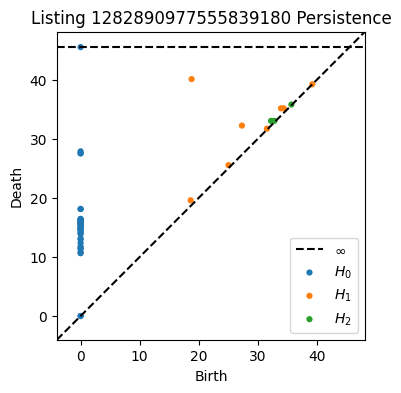

In [5]:
listing_diag = compute_listing_persistence(df_ts_interp, dates, window_size=14, delay=1)

# plot one example (first listing)
first_id, first_dgms = next(iter(listing_diag.items()))
plt.figure(figsize=(6,4))
plot_diagrams(first_dgms, show=True, title=f"Listing {first_id} Persistence")

/var/folders/c2/hxfkbjc14h9d9m0ch12z7qh00000gn/T/ipykernel_28840/1285233101.py:56: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/sbaca/micromamba/envs/global_env/lib/python3.11/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

/Users/sbaca/micromamba/envs/global_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Users/sbaca/micromamba/envs/global_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Users/sbaca/micromamba/envs/global_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



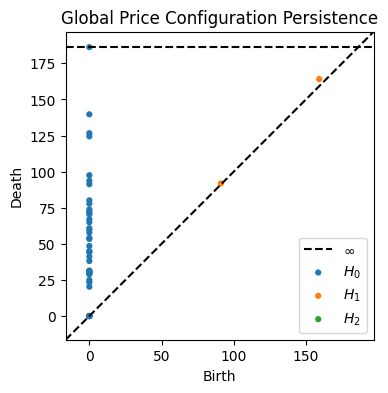

In [6]:
global_dgms = compute_global_persistence(df_ts_interp, dates)
plt.figure(figsize=(6,4))
plot_diagrams(global_dgms, show=True, title="Global Price Configuration Persistence")